In [1]:
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist = np.concatenate([x_train, x_test], axis=0)
mnist = np.expand_dims(mnist, -1).astype("float32") / 255

In [4]:
LATENT_DIM = 2

In [5]:
class Sampler(keras.layers.Layer):
    def call(self, z_mean, z_log_var):
        eps = tf.random.normal(shape=z_mean.shape)
        return z_mean + tf.exp(0.5 * z_log_var) * eps

In [6]:
def make_encoder():
    inputs = keras.Input(shape=(28, 28, 1))
    x = keras.layers.Conv2D(32, kernel_size=3, strides=2, activation="relu", padding="same")(inputs)
    x = keras.layers.Conv2D(64, kernel_size=3, strides=2, activation="relu", padding="same")(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(16, activation="relu")(x)
    
    z_mean = keras.layers.Dense(LATENT_DIM, name="z_mean")(x)
    z_log_var = keras.layers.Dense(LATENT_DIM, name="z_log_var")(x)
    return keras.Model(inputs, [z_mean, z_log_var], name="encoder")

In [7]:
def make_decoder():
    inputs = keras.Input(shape=(LATENT_DIM, ))
    x = keras.layers.Dense(3_136, activation="relu")(inputs)  # same unit numbers of encoder flattern layer.
    x = keras.layers.Reshape((7, 7, 64))(x)
    x = keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation="relu", padding="same")(x)
    x = keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation="relu", padding="same")(x)
    x = keras.layers.Conv2D(1, kernel_size=3, activation="sigmoid", padding="same")(x)  # back to (1, 28, 28)
    
    return keras.Model(inputs, x, name="decoder")

In [8]:
class VAE(keras.Model):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.encoder = make_encoder()
        self.decoder = make_decoder()
        self.sampler = Sampler()
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = self.decoder(z)
            
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))  # mean on batch
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + kl_loss
        
        gradients = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {"total_loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}

In [9]:
vae = VAE()
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
vae.fit(mnist, epochs=100, batch_size=2048)

Epoch 1/100
35/35 [==============================] - 9s 140ms/step - total_loss: 387.7308 - reconstruction_loss: 382.4412 - kl_loss: 2.0764
Epoch 2/100
35/35 [==============================] - 5s 133ms/step - total_loss: 226.1013 - reconstruction_loss: 225.8477 - kl_loss: 0.0133
Epoch 3/100
35/35 [==============================] - 5s 133ms/step - total_loss: 212.0897 - reconstruction_loss: 211.9236 - kl_loss: 0.0095
Epoch 4/100
35/35 [==============================] - 5s 135ms/step - total_loss: 210.0687 - reconstruction_loss: 210.0584 - kl_loss: 0.0109
Epoch 5/100
35/35 [==============================] - 5s 134ms/step - total_loss: 208.7618 - reconstruction_loss: 208.7341 - kl_loss: 0.0237
Epoch 6/100
35/35 [==============================] - 5s 133ms/step - total_loss: 207.0752 - reconstruction_loss: 206.8808 - kl_loss: 0.1456
Epoch 7/100
35/35 [==============================] - 5s 132ms/step - total_loss: 202.5829 - reconstruction_loss: 201.5572 - kl_loss: 0.9168
Epoch 8/100
35/35 [=

In [10]:
def make_fig(num):

  grid_x = np.linspace(-1, 1, num)
  grid_y = np.linspace(-1, 1, num)[::-1]

  meshgrid = np.meshgrid(grid_x, grid_y)
  grids = np.append(meshgrid[0].reshape(-1, 1), meshgrid[1].reshape(-1, 1) ,axis=1)
  
  results = vae.decoder.predict(grids).squeeze().reshape(num, num, 28, 28)

  return results

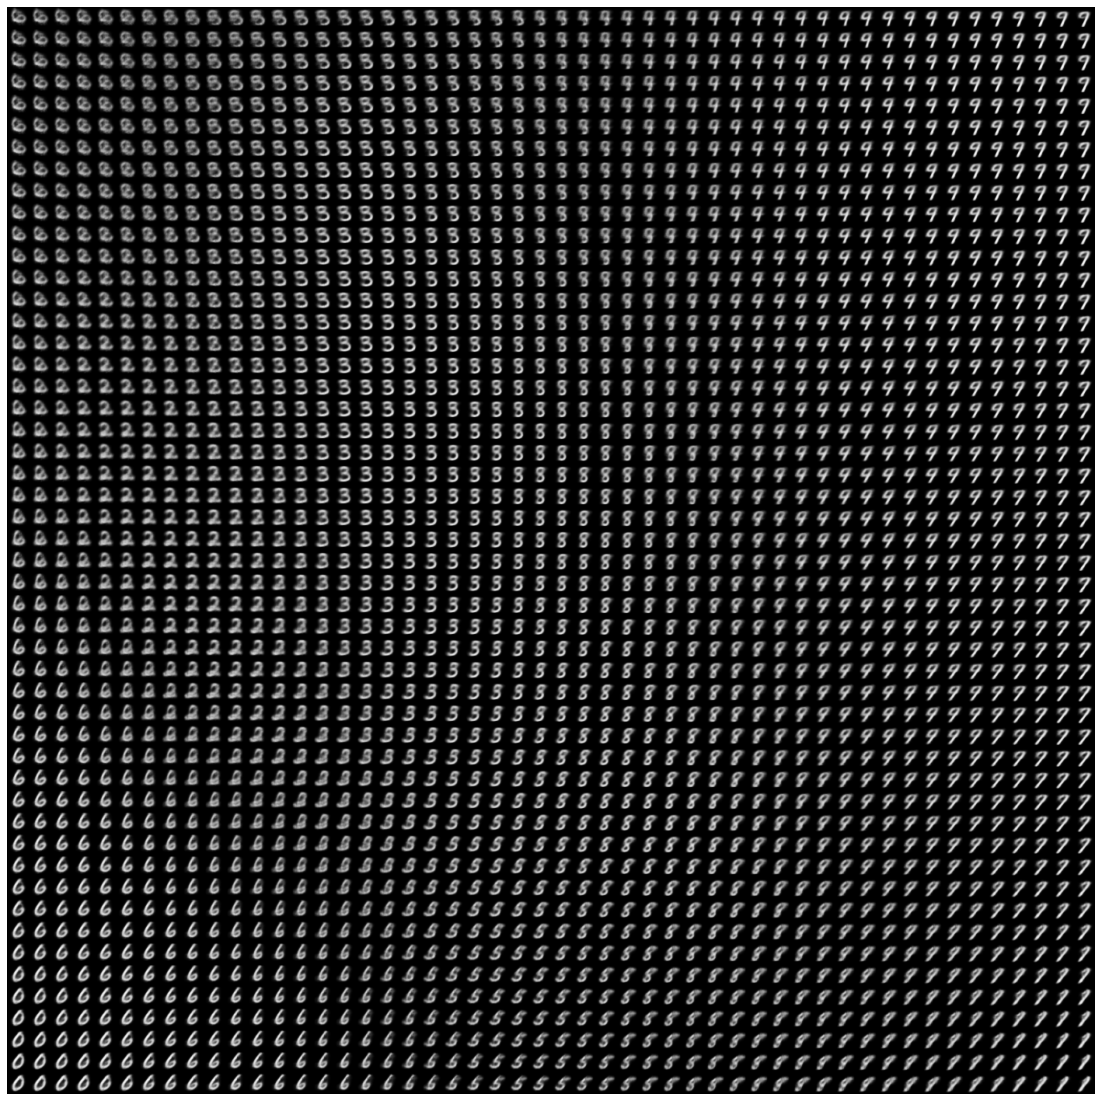

In [30]:
import matplotlib.pyplot as plt

n = 50
img = make_fig(n)

fig = np.zeros((n * 28, n * 28))
for i in range(n):
  for j in range(n):
    fig[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = img[i, j]

plt.figure(figsize=(20, 20))
plt.axis("off")
plt.imshow(fig, cmap='gray');